In [1]:
# ----------------------------------------------------------
# 0.  Imports
# ----------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, ks_2samp

In [13]:
plt.style.use("seaborn-v0_8-whitegrid")  # nicer default look

# ----------------------------------------------------------
# 1.  Load and clean data
# ----------------------------------------------------------
CSV_PATH = "/Users/souba636/Documents/vinnova_project_python/data/scenario/blackhole_var10_oo/blackhole_var10_oo_1_features_timeseries_60_sec.csv"

df = pd.read_csv(CSV_PATH)

# Drop index-like column if present
for col in ("Unnamed: 0", "index"):
    if col in df.columns:
        df = df.drop(columns=[col])


In [14]:

# ----------------------------------------------------------
# 2.  Quick sanity check – class balance
# ----------------------------------------------------------
print("Class balance:")
display(df["label"].value_counts().rename({0: "Normal (0)", 1: "Attack (1)"}))


Class balance:


label
Normal (0)    274
Attack (1)    121
Name: count, dtype: int64

In [16]:
# ----------------------------------------------------------
# 3.  Per-feature descriptive statistics and tests
# ----------------------------------------------------------
numeric_cols = df.select_dtypes(np.number).columns.drop("label")

records = []
for feat in numeric_cols:
    grp0 = df.loc[df["label"] == 0, feat]
    grp1 = df.loc[df["label"] == 1, feat]

    # Skip if feature is constant
    if grp0.nunique() <= 1 and grp1.nunique() <= 1:
        continue

    # Mean difference
    mean0, mean1 = grp0.mean(), grp1.mean()
    mean_diff = mean1 - mean0

    # Welch t-test (does not assume equal variances)
    t_stat, p_ttest = ttest_ind(grp1, grp0, equal_var=False, nan_policy="omit")

    # Kolmogorov–Smirnov test
    ks_stat, p_ks = ks_2samp(grp1, grp0, alternative="two-sided")

    records.append(
        {
            "feature": feat,
            "mean_0": mean0,
            "mean_1": mean1,
            "mean_diff": mean_diff,
            "t_stat": t_stat,
            "p_ttest": p_ttest,
            "ks_stat": ks_stat,
            "p_ks": p_ks,
        }
    )

results = (
    pd.DataFrame(records)
      .assign(abs_mean_diff=lambda d: d["mean_diff"].abs())
      .sort_values("abs_mean_diff", ascending=False)
      .reset_index(drop=True)
)

# Flag features that pass a significance threshold (e.g. α = 0.05)
alpha = 0.05
results["sig_ttest"] = results["p_ttest"] < alpha
results["sig_ks"] = results["p_ks"] < alpha

print("\nPer-feature comparison (sorted by |mean diff|):")
display(results)   # show top 20; change as you wish



Per-feature comparison (sorted by |mean diff|):


,feature,mean_0,mean_1,mean_diff,t_stat,p_ttest,ks_stat,p_ks,abs_mean_diff,sig_ttest,sig_ks
0,dior,1.025536,3.324192,2.298656,28.459448,5.378478e-80,0.911232,2.300921e-76,2.298656,True,True
1,rank,347.080441,344.938234,-2.142208,-2.874811,4.274168e-03,0.124208,1.353889e-01,2.142208,True,False
2,dior.1,0.986219,3.011460,2.025241,31.242312,4.339984e-69,0.953309,1.569724e-87,2.025241,True,True
3,dios.1,0.566475,1.652337,1.085863,27.066133,2.863274e-55,0.952344,4.895080e-87,1.085863,True,True
4,tots.1,0.584059,1.659860,1.075801,26.223589,3.695652e-54,0.942360,2.612692e-84,1.075801,True,True
5,tots,0.713336,1.172867,0.459531,16.745251,1.377029e-42,0.670899,1.222179e-36,0.459531,True,True
6,dios,0.680003,1.138507,0.458504,17.159377,3.263136e-43,0.712765,6.999283e-42,0.458504,True,True
7,rank.1,86.567226,86.309497,-0.257729,-0.583930,5.596340e-01,0.131508,9.829803e-02,0.257729,False,False
8,diar.1,0.066024,0.071434,0.005411,0.289592,7.723178e-01,0.081559,5.954810e-01,0.005411,False,False
9,diar,0.023439,0.024735,0.001296,0.194187,8.461535e-01,0.081559,5.954810e-01,0.001296,False,False


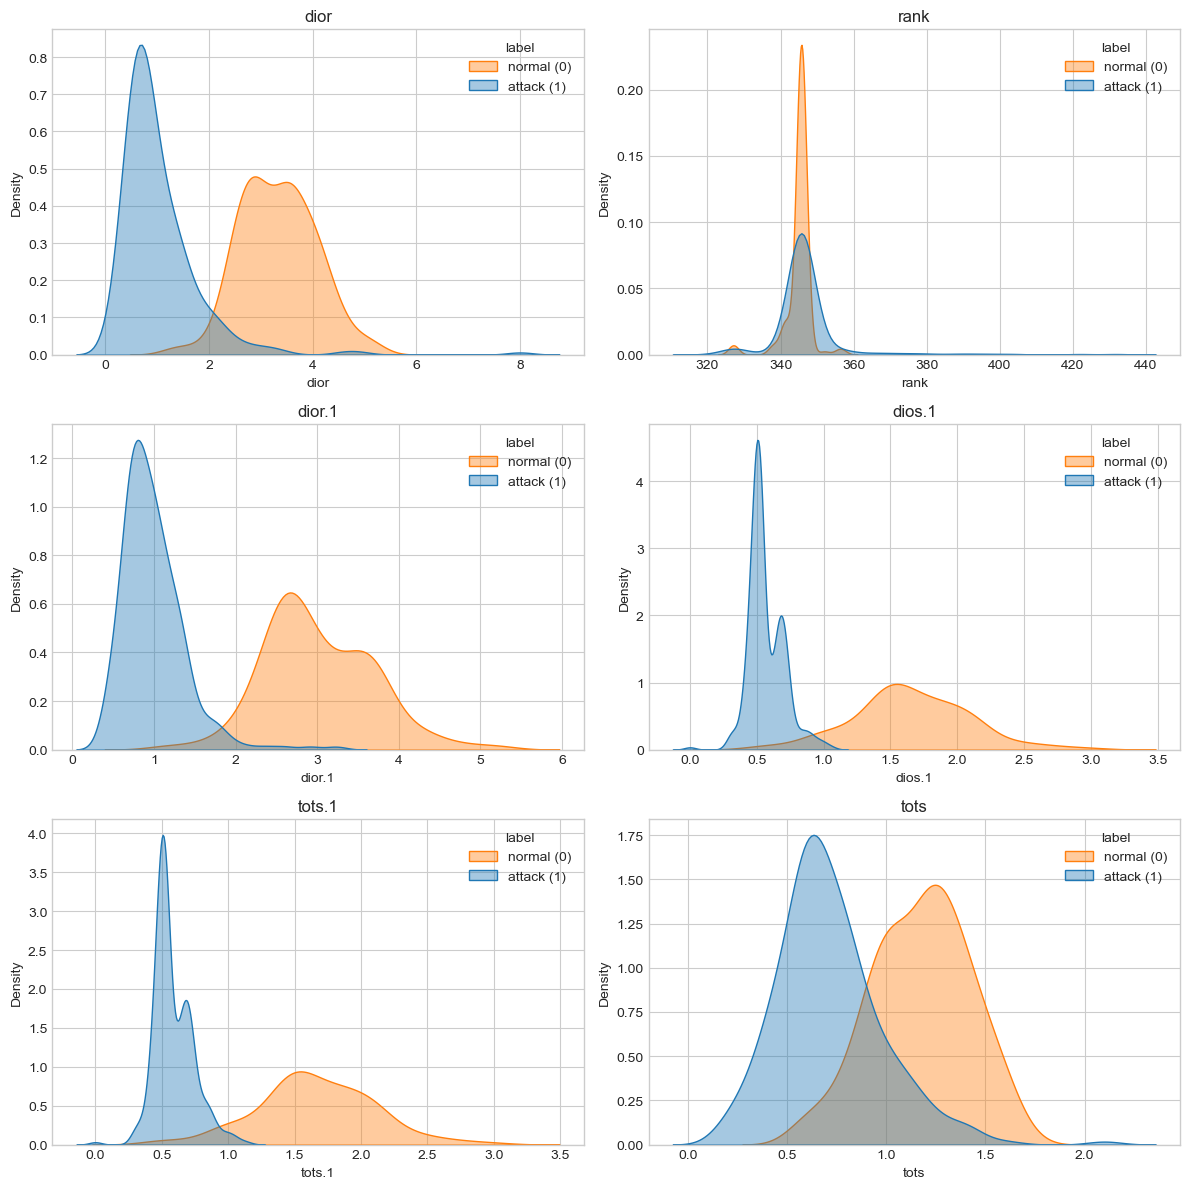

In [17]:
# ----------------------------------------------------------
# 4.  Visualise the N features with largest absolute mean diff
# ----------------------------------------------------------
TOP_N_PLOTS = 6   # tweak for more/less plots
top_feats = results.head(TOP_N_PLOTS)["feature"]

n_rows = int(np.ceil(TOP_N_PLOTS / 2))
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows), squeeze=False)

for ax, feat in zip(axes.ravel(), top_feats):
    sns.kdeplot(
        data=df, x=feat, hue="label",
        common_norm=False, fill=True, alpha=0.4, ax=ax,
        palette={0: "#1f77b4", 1: "#ff7f0e"}
    )
    ax.set_title(feat)
    ax.legend(title="label", labels=["normal (0)", "attack (1)"])

# Hide any unused subplots
for ax in axes.ravel()[len(top_feats):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


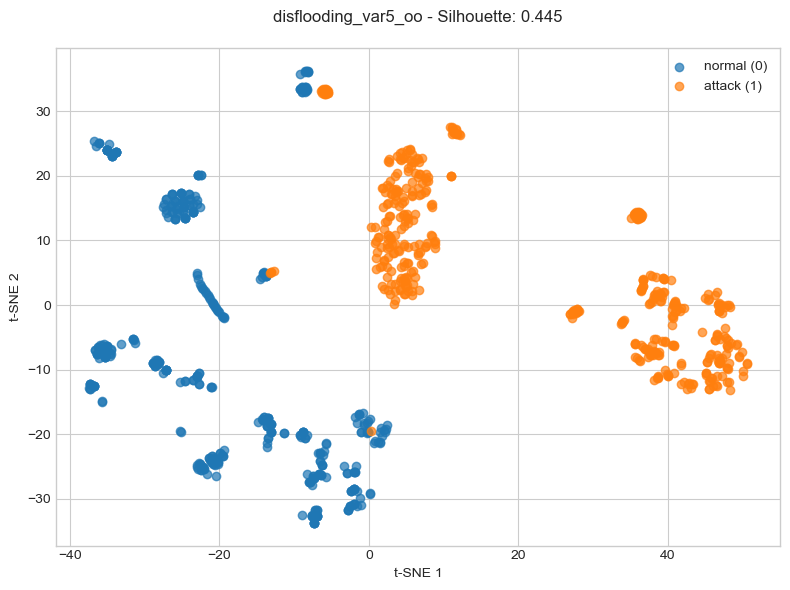

Silhouette score in t-SNE space: 0.445


In [39]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# csv_path = "/Users/souba636/Documents/vinnova_project_python/data/scenario/blackhole_var10_oo/blackhole_var10_oo_1_features_timeseries_60_sec.csv"
csv_path = "/Users/souba636/Documents/vinnova_project_python/data/scenario/disflooding_var5_oo/disflooding_var5_oo_10_features_timeseries_60_sec.csv"


# ─────────────────────────────────────────────
# 1.  Load the data (features + label)
# ─────────────────────────────────────────────
if not os.path.exists(csv_path):
    print(" Dataset file not found!\n"
          " Upload the CSV or fix csv_path and re-run.")
else:
    df = pd.read_csv(csv_path)

    # Drop index-like column if present
    for col in ('Unnamed: 0', 'index'):
        if col in df.columns:
            df = df.drop(columns=[col])

    # Separate features and labels
    X = df.drop(columns=['label'])
    y = df['label'].values

    # ─────────────────────────────────────────
    # 2.  Scale then apply 2-D t-SNE
    # ─────────────────────────────────────────
    X_scaled = StandardScaler().fit_transform(X)
    X_emb    = TSNE(
        n_components=2, init='pca', random_state=42, perplexity=30
    ).fit_transform(X_scaled)

    # ─────────────────────────────────────────
    # 3.  Quick numeric check: silhouette score
    #     (> 0.5 ≈ well separated, < 0 ≈ overlap)
    # ─────────────────────────────────────────
    sil = silhouette_score(X_emb, y)

    # ─────────────────────────────────────────
    # 4.  Scatter plot
    # ─────────────────────────────────────────
        
    plt.figure(figsize=(8, 6))

    label_names = {0: "normal (0)", 1: "attack (1)"}   # ← new

    for lbl in np.unique(y):
        mask = y == lbl
        plt.scatter(
            X_emb[mask, 0],
            X_emb[mask, 1],
            label=label_names.get(lbl, f"class {int(lbl)}"),   # ← use the mapping
            alpha=0.7,
        )

    scenario = os.path.basename(os.path.dirname(csv_path))
    plt.title(f"{scenario} - Silhouette: {sil:.3f}\n")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend()
    plt.tight_layout()
    plt.show()


    print(f"Silhouette score in t-SNE space: {sil:.3f}")
